# Cálculo de $\pi$ con el Método de Montecarlo

In [27]:
import os,sys,time
import matplotlib.pyplot as plot
import numpy as np
import matplotlib
import time
import ipyparallel as ipp
rc = ipp.Client()
print "available engines", rc.ids

available engines [0, 1, 2, 3]


In [3]:
%px print "hola"

[stdout:0] hola
[stdout:1] hola
[stdout:2] hola
[stdout:3] hola


## <font style="color: red">TAREA 1: Escribe una función que, si sacamos $N$ números aleatorios, cuente cuantos caen dentro de un círculo de radio 1</font>

In [4]:
%%px --local
import numpy as np
from random import random
from math import sqrt

In [5]:
%%px --local
def count_inside(N):
    ok = 0.
    for i in range(N):
        x,y = random(), random()
        d = sqrt(x ** 2.0 + y ** 2.0)
        if d < 1:
            ok += 1.
    return ok

In [6]:
N = 1000000 #4*1e5
t = %timeit -o -r 3 -n 2 count_inside(N)*4./N
print "pi estimado", count_inside(N)*4./N
print "tiempo     ", t.best, "[sec]"

2 loops, best of 3: 2.23 s per loop
pi estimado 3.143908
tiempo      2.23258292675 [sec]


## <font style="color: red">TAREA 2: Usa `dv.apply` con la función anterior para distribuir $N$ entre los nodos disponibles en el cluster</font>

In [7]:
dv = rc.direct_view()
print rc.ids
NumNodos = np.count_nonzero(rc.ids)+1 #numero de nodos disponibles
print("Numero de Nodos: " + str(NumNodos))

[0, 1, 2, 3]
Numero de Nodos: 4


Define primero tu función en todos los nodos

In [8]:
dr = dv.apply(count_inside,N/NumNodos) #cada nodo se encarga de correr N/número de nodos iteraciones y cada uno me devuelve u valor de aciertos
dr.get()

[196616.0, 196078.0, 196506.0, 196800.0]

Usa `dv.apply` o `dv.map` para ejecutar tu función en paralelo. Ten en cuanta de que si hay k nodos y quieres usar N puntos, cada nodo tendrá que usar N/k puntos.

In [10]:
TodosLosResultados = 0.
for i in range(NumNodos): #recorrro los resultados de mis nodos y los sumo
    TodosLosResultados += (dr.r[i])
print "pi estimado", TodosLosResultados*4./N
print "tiempo     ", dr.elapsed, "[sec]"
if dr.elapsed < t.best:
    print "ha sido mas eficiente el paralelizar en: ", (t.best/dr.elapsed), " veces más rápido"
else:
    print "ha sido mas eficiente sin paralelizar."

pi estimado 3.144
tiempo      0.831335 [sec]
ha sido mas eficiente el paralelizar en:  2.68553943567  veces más rápido


In [11]:
for i in range(NumNodos):
    inicia = dr.metadata[i]['started']
    termina = dr.metadata[i]['completed']
    #recibe = dr.metadata[i]['received']
    #enviada = dr.metadata[i]['submitted']
    print "Nodo N° ", dr.metadata[i]['engine_id'], "demoró en la tarea. ", (termina-inicia).total_seconds() , "[sec]"
    

Nodo N°  0 demoró en la tarea.  0.658086 [sec]
Nodo N°  1 demoró en la tarea.  0.756227 [sec]
Nodo N°  2 demoró en la tarea.  0.683876 [sec]
Nodo N°  3 demoró en la tarea.  0.697318 [sec]


## <font style="color:red"> TAREA 3: Ejecuta tu código con 1,2,3... engines y obtén la curva de escalabilidad


In [12]:
Lista = []
Parametros = []
tiempos = []
for i in range(NumNodos):
    Parametros = []
    for j in range(i+1):
        Parametros.append(N/(i+1))
    start_time = time.time()
    drn = dv.map_sync(count_inside,Parametros)
    end_time = time.time()
    tiempos.append(end_time-start_time) #el tiempo que demora cada hace las operaciones
    Lista.append(drn)#guardo la lista de resultados
    print "Número de Nodo: ", i
    print "Parametros:", Parametros
    print "Lista: ", Lista
    print "Tiempos: ", tiempos
    print "-------------------"

Número de Nodo:  0
Parametros: [1000000]
Lista:  [[785947.0]]
Tiempos:  [2.106235980987549]
-------------------
Número de Nodo:  1
Parametros: [500000, 500000]
Lista:  [[785947.0], [392733.0, 392167.0]]
Tiempos:  [2.106235980987549, 1.1833760738372803]
-------------------
Número de Nodo:  2
Parametros: [333333, 333333, 333333]
Lista:  [[785947.0], [392733.0, 392167.0], [261606.0, 261783.0, 261578.0]]
Tiempos:  [2.106235980987549, 1.1833760738372803, 0.8520700931549072]
-------------------
Número de Nodo:  3
Parametros: [250000, 250000, 250000, 250000]
Lista:  [[785947.0], [392733.0, 392167.0], [261606.0, 261783.0, 261578.0], [196206.0, 196175.0, 196408.0, 196620.0]]
Tiempos:  [2.106235980987549, 1.1833760738372803, 0.8520700931549072, 0.9107520580291748]
-------------------


In [30]:
x = range(NumNodos)
y = tiempos
print x,y

[0, 1, 2, 3] [2.106235980987549, 1.1833760738372803, 0.8520700931549072, 0.9107520580291748]


En una máquina con cuatro procesadores, una posible curva sería esta

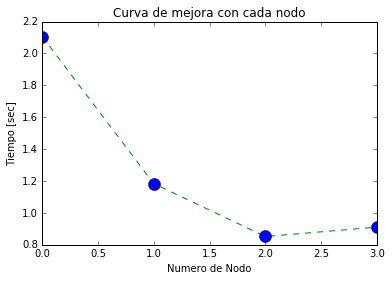

In [34]:
%matplotlib inline
plot.plot(x, y, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
plot.xlabel('Numero de Nodo')
plot.ylabel('Tiempo [sec]')
plot.title('Curva de mejora con cada nodo')

In [18]:
%load_ext version_information
%version_information matplotlib, sympy, numpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.11 32bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.1
OS Linux 3.16.7 ckt20 smp i686 with debian 8.2
matplotlib 1.5.1
sympy 0.7.6.1
numpy 1.10.4
Thu Jun 09 08:23:09 2016 COT

In [35]:
!lscpu

Architecture:          i686
CPU op-mode(s):        32-bit
Byte Order:            Little Endian
CPU(s):                4
On-line CPU(s) list:   0-3
Thread(s) per core:    1
Core(s) per socket:    4
Socket(s):             1
Vendor ID:             AuthenticAMD
CPU family:            22
Model:                 48
Model name:            AMD A8-6410 APU with AMD Radeon R5 Graphics
Stepping:              1
CPU MHz:               1996.258
BogoMIPS:              3992.51
Hypervisor vendor:     KVM
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              2048K
